In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os
from matplotlib.animation import FuncAnimation

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/tdarcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'

sublogdir = 'massconservation'

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['discretization_device'] = 'cpu'
projection.hparams['n_timesteps'] = 10
projection.hparams['Dt'] = 1/10
projection.hparams['output_coefficients'] = True
projection.__init__(projection.hparams)

FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['discretization_device'] = 'cpu'
FEM.hparams['n_timesteps'] = 10
FEM.hparams['Dt'] = 1/10
FEM.hparams['output_coefficients'] = True
FEM.__init__(FEM.hparams)

modelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_4x10x10', logdir=logdir, sublogdir=sublogdir, device=device)
modelNGO.hparams['discretization_device'] = 'cpu'
modelNGO.hparams['n_timesteps'] = 10
modelNGO.hparams['Dt'] = 1/10
modelNGO.hparams['output_coefficients'] = True
modelNGO.__init__(modelNGO.hparams)


modeldict = {'Projection': projection,
             'FEM': FEM,
             #'NN': NN,
             #'DeepONet': DeepONet,
             #'VarMiON': VarMiON,
            #'Data NGO': dataNGO,
            #'Data-free NGO': datafreeNGO,
            'Model NGO': modelNGO}

In [6]:
N_samples = 1

timesteps = 101

tau = 0.1
l = 0.1

T, X, Y = np.mgrid[0:1:timesteps*1j, 0:1:101*1j, 0:1:101*1j]
x = np.vstack([T.ravel(), X.ravel(), Y.ravel()]).T
    
dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[tau,l,l], l_max=[tau,l,l], device='cpu')
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u0 = dataset.u0

In [7]:
u_exact = discretize_functions(u, x, dtype=modelNGO.hparams['dtype'], device='cpu')
u_proj = projection.simforward(theta, f, etab, etat, gl, gr, u0, x, u)
u_hat = modelNGO.simforward(theta, f, etab, etat, gl, gr, u0, x, u)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


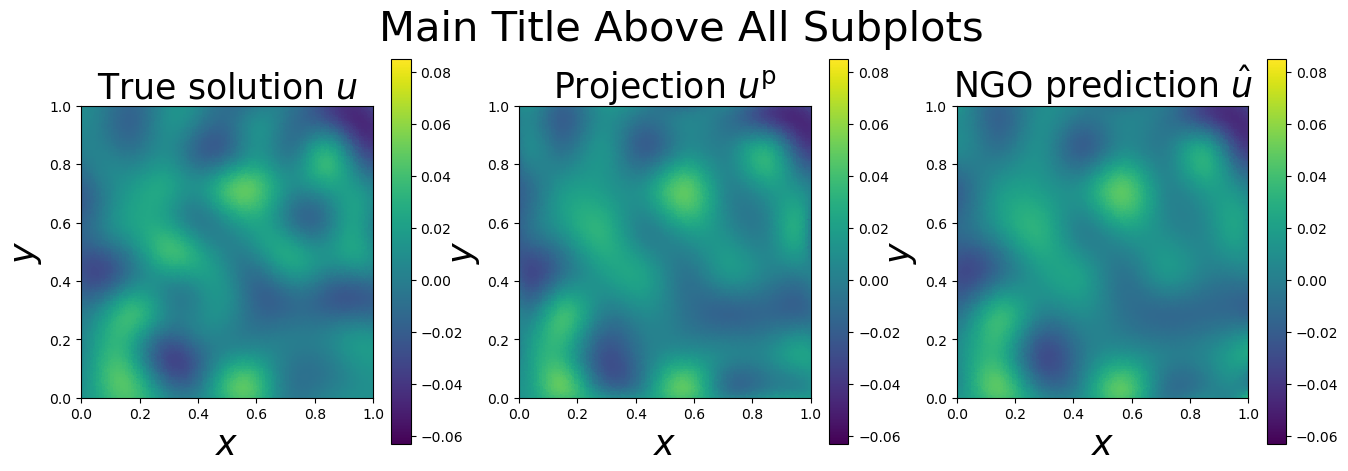

In [8]:
t = 0.1

# Create grid
size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0)

ax = axs[0]
fig = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_exact[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('True solution $u$', fontsize=size_title)
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_proj[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('Projection $u^{\mathrm{p}}$', fontsize=size_title)
plt.colorbar(fig)

ax = axs[2]
fig = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_hat[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('NGO prediction $\hat{u}$', fontsize=size_title)
plt.colorbar(fig)

plt.suptitle('Main Title Above All Subplots', fontsize=30)
plt.show()

0.0
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0
0.0


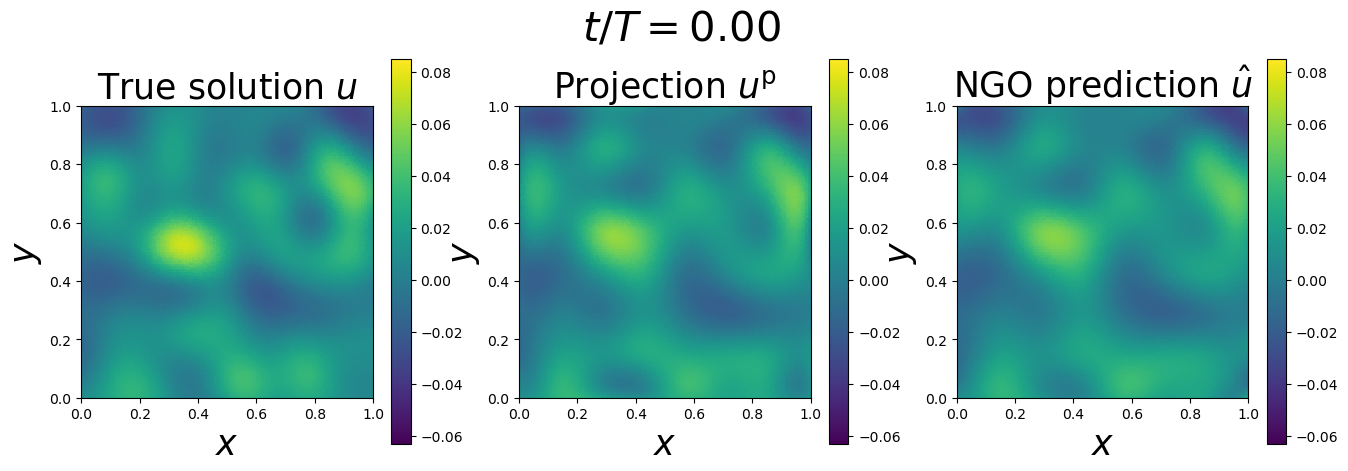

: 

In [ ]:
# Animation parameters
size_title = 20
size_ticklabels = 15
size_axeslabels = 25
t_values = np.linspace(0, 1, timesteps)  # Time steps for the animation

# Create grid
size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

ax = axs[0]
tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_exact[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('True solution $u$', fontsize=size_title)
cbar = plt.colorbar(tripcolor_plot, ax=ax)

ax = axs[1]
tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_proj[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('Projection $u^{\mathrm{p}}$', fontsize=size_title)
cbar = plt.colorbar(tripcolor_plot, ax=ax)

ax = axs[2]
tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_hat[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('NGO prediction $\hat{u}$', fontsize=size_title)
cbar = plt.colorbar(tripcolor_plot, ax=ax)

# Update function for the animation
def update(t):
    print(t)

    ax = axs[0]
    tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_exact[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
    ax = axs[1]
    tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_proj[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
    ax = axs[2]
    tripcolor_plot = ax.tripcolor(x[:,1][x[:,0]==t], x[:,2][x[:,0]==t],u_hat[0][x[:,0]==t], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))

    # ax.set_title(f'Time: {t:.2f}', fontsize=size_title)
    plt.suptitle(f'$t/T=${t:.2f}', fontsize=30)

# Create the animation
ani = FuncAnimation(fig, update, frames=t_values, repeat=False)

# Save or display animation
ani.save('animation_timestepping.gif', writer='pillow', fps=10)
# plt.show()  # Uncomment to display the animation
